# Task 08 – GA4 Daily User Analysis

This notebook performs an analysis of Google Analytics 4 sample ecommerce data.
It queries and processes data directly in BigQuery, following the assignment.

### 08a – Query raw GA4 data
This step creates a new BigQuery table containing the number of events and total revenue per user for January 15–31, 2021.

In [18]:
#Set up BigQuery client
from google.cloud import bigquery

project_id = "oamk-476515"
client = bigquery.Client(project=project_id)

c:\Users\nicot\code\data-engineering\.venv\Lib\site-packages\google\auth\_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


### 08b – Write query results to BigQuery
This query extracts the purchase revenue from the nested `event_params` structure and it saves results to `oamk-476515.G4_daily_user.G4_daily_user_data`.

In [25]:
from google.cloud import bigquery

# Initialize client
project_id = "oamk-476515"
client = bigquery.Client(project=project_id)

# Dataset and table destination
dataset_id = f"{project_id}.G4_daily_user"
table_id = f"{dataset_id}.G4_daily_user_data"

# SQL query
query = """
SELECT
  user_pseudo_id,
  COUNT(event_name) AS event_count,
  SUM(
    COALESCE(
      (SELECT ep.value.int_value
       FROM UNNEST(event_params) AS ep
       WHERE ep.key = 'value'),
      0)
  ) AS total_revenue
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20210101' AND '20210131'
  AND event_name = 'purchase'
GROUP BY
  user_pseudo_id
ORDER BY
  total_revenue DESC;
"""

# Configure destination
job_config = bigquery.QueryJobConfig(
    destination=table_id,
    write_disposition="WRITE_TRUNCATE"
)

# Run query directly in BigQuery
query_job = client.query(query, job_config=job_config)
query_job.result()  # wait for completion

print(f"Query executed (results saved to {table_id})")


c:\Users\nicot\code\data-engineering\.venv\Lib\site-packages\google\auth\_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Query executed (results saved to oamk-476515.G4_daily_user.G4_daily_user_data)


### 08c – Query created table into pandas
The data stays in BigQuery during processing and is only loaded at the end for local analysis and visualization.

In [26]:
from google.cloud import bigquery
import pandas as pd

# Initialize client
project_id = "oamk-476515"
client = bigquery.Client(project=project_id)

# Table location
table_id = f"{project_id}.G4_daily_user.G4_daily_user_data"

# Query data from the created table
query = f"SELECT * FROM `{table_id}` ORDER BY total_revenue DESC"

# Load into pandas DataFrame
df = client.query(query).to_dataframe()

# Show basic info
print(f"Loaded {len(df)} rows from {table_id}")
df.head()


c:\Users\nicot\code\data-engineering\.venv\Lib\site-packages\google\auth\_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
c:\Users\nicot\code\data-engineering\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Loaded 1069 rows from oamk-476515.G4_daily_user.G4_daily_user_data


,user_pseudo_id,event_count,total_revenue
0,7134559299.4601048201,1,1200
1,72275845.1755516158,1,395
2,53406211.8724008214,1,276
3,4229717.4815659011,1,209
4,7191442.1007439176,1,182


### 08d – Visualization of top 20 users
This bar chart shows the top 20 users ranked by total revenue between January 15–31, 2021.

moo 281 15730


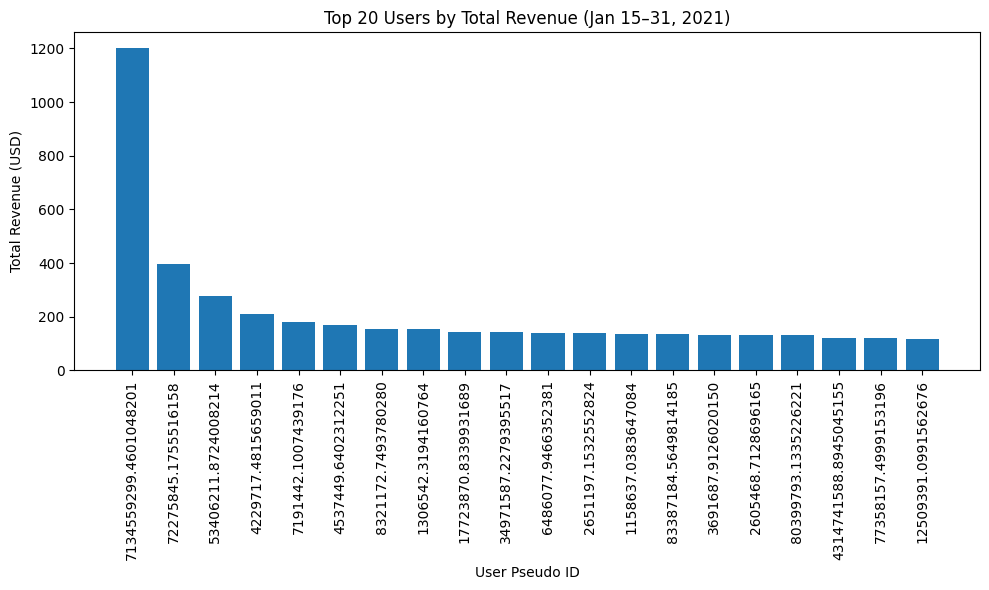

In [27]:
import matplotlib.pyplot as plt

# Sort by revenue and pick top 20
top_users = df.sort_values("total_revenue", ascending=False).head(20)

print("moo", (df["total_revenue"] > 0).sum(), df["total_revenue"].sum())

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_users["user_pseudo_id"].astype(str), top_users["total_revenue"])
plt.xticks(rotation=90)
plt.xlabel("User Pseudo ID")
plt.ylabel("Total Revenue (USD)")
plt.title("Top 20 Users by Total Revenue (Jan 15–31, 2021)")
plt.tight_layout()
plt.show()
